In [1]:
import pandas as pd
import os

import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
import astropy.units as u
from astropy.table import Table, vstack
import astropy
from astropy.coordinates import SkyCoord
import getpass

import lsst.afw.display as afwDisplay
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import lsst.afw.math as afwMath
from lsst.daf.butler import Butler
from lsst.daf.butler.registry import ConflictingDefinitionError
import lsst.geom as geom
from lsst.source.injection import ingest_injection_catalog, generate_injection_catalog
from lsst.source.injection import VisitInjectConfig, VisitInjectTask
from lsst.ip.diffim.subtractImages import AlardLuptonSubtractTask, AlardLuptonSubtractConfig

from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.meas.base import ForcedMeasurementTask
import lsst.daf.base as dafBase
import lsst.afw.table as afwTable

# Define repo and collection where I have the coadd

In [2]:
repo = '/global/cfs/cdirs/lsst/production/gen3/DC2/Run3.1i/repo'
# These are the collections containing the Y1 processed visit images, etc..
# collections = ['u/taceroc/custom_coadd_test_3_422025',]
collections = ['u/taceroc/custom_coadd_test_2_442025']
# collections = ['u/jchiang8/coadds_ddf_y1-y2_4848_assembleCoadd']

In [3]:
calexp_butler = Butler(repo, collections=collections)

In [4]:
list(calexp_butler.registry.queryDatasets('deepCoadd'))

[DatasetRef(DatasetType('deepCoadd', {band, skymap, tract, patch}, ExposureF), {band: 'g', skymap: 'DC2', tract: 4849, patch: 31}, run='u/taceroc/custom_coadd_test_2_442025/20250404T182024Z', id=63fc527d-54e0-4203-9080-31287c23b4fe)]

In [5]:
coadd = calexp_butler.get(list(calexp_butler.registry.queryDatasets('deepCoadd'))[0])

In [6]:
afwDisplay.setDefaultBackend('matplotlib')
plt.style.use('tableau-colorblind10')

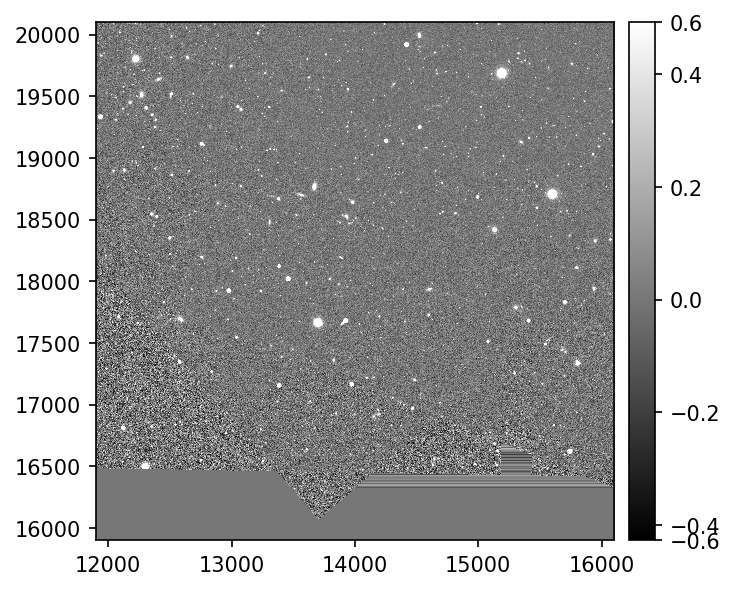

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150)

display2 = afwDisplay.Display(frame=fig)
display2.scale('linear', 'zscale')
# display2.scale('linear', min=-20, max=150)
display2.mtv(coadd.image)

plt.tight_layout()
plt.show()

# Plot LE fits

In [8]:
stamp_img_hdu = fits.open('fits/surface_valuesInfPlane_dt0_loop_ct230_loc[0.9, -1.3, 1, -32.6156]_dz0.06_w673_angle[30, 155].fits')
fits_img = stamp_img_hdu[0].data
stamp_img_hdu.close()

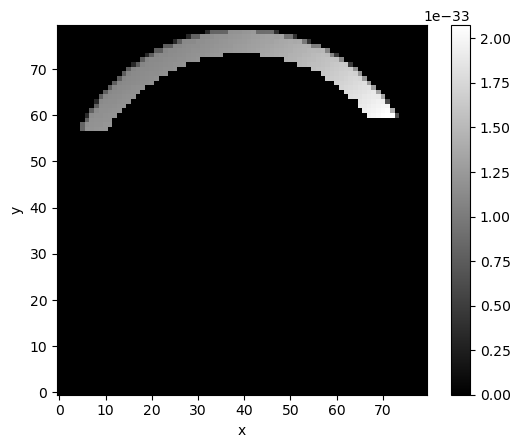

In [9]:
fig = plt.figure()
plt.subplot()
im = plt.imshow(fits_img, cmap='gray', origin='lower')
plt.colorbar(im)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Define location of LE injection on calexp

Use pixel location, then convert to radec

check that calexp contain the location

In [10]:
coadd.getBBox().getCorners()[0][0]

11900

In [11]:
x = coadd.getBBox().getCorners()[2][0] - 200
y = coadd.getBBox().getCorners()[2][1] - 200
radec = coadd.getWcs().pixelToSky(geom.Point2D(x, y))

In [12]:
radec

SpherePoint(53.71146051328977*degrees, -28.68043707265845*degrees)

In [13]:
coadd.containsSkyCoords(radec.getRa().asAngularUnits(geom.degrees)*u.deg, radec.getDec().asAngularUnits(geom.degrees)*u.deg)

array([ True])

In [14]:
bbox = coadd.getBBox()
wcs = coadd.getWcs()

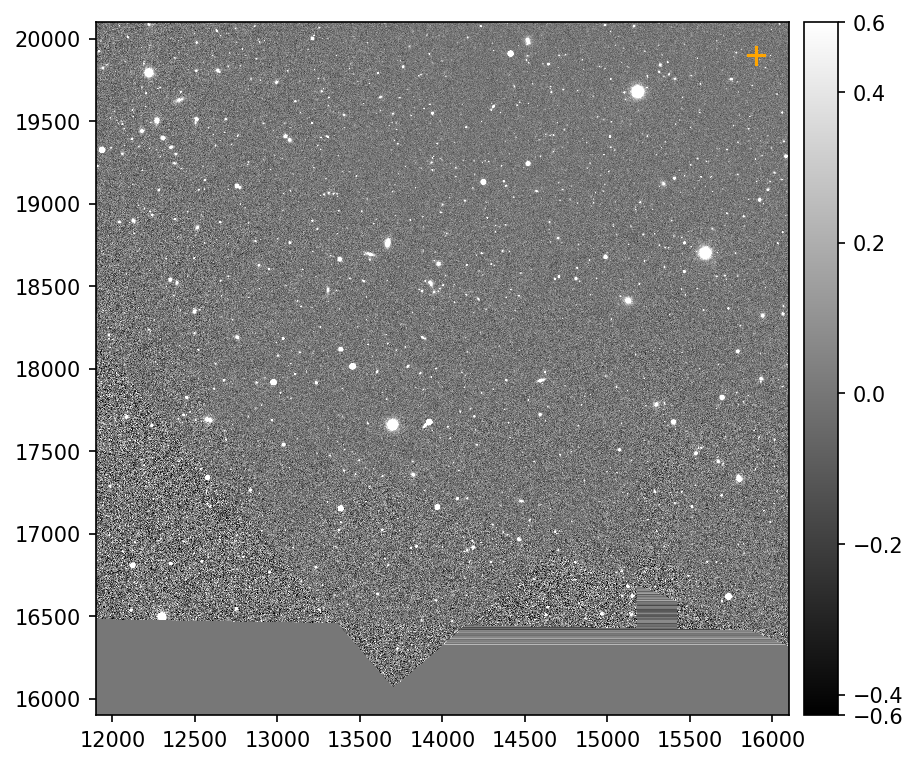

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=150)

display0 = afwDisplay.Display(frame=fig)
display0.scale('linear', 'zscale')
# display0.scale('linear', min=-20, max=150)
display0.mtv(coadd.image)

# wcs = deepCoadd_test.getWcs()
center = wcs.skyToPixel(radec)
display0.dot('+', center.x, center.y, size=50, ctype='orange')

# Create injection catalog

I followed DP02_14_Injecting_Synthetic_Sources.ipynb

In [16]:
my_injection_catalog_stamp = Table(
    {
        'injection_id': [9999],
        'ra': [round(radec.getRa().asAngularUnits(geom.degrees),2)],
        'dec': [round(radec.getDec().asAngularUnits(geom.degrees),2)],
        'source_type': ['Stamp'],
        'mag': [24],
        'stamp': ['fits/surface_valuesInfPlane_dt0_loop_ct230_loc[0.9, -1.3, 1, -32.6156]_dz0.06_w673_angle[30, 155].fits'],
    }
)

In [17]:
user = os.getenv("USER")
# butler remove-runs dp02 u/taceroc/test_LEinjection_inputs_2
INJECTION_CATALOG_COLLECTION = f"u/{user}/test_LEinjection_inputs_1_442025_custom_coadd_test_2_442025"

In [18]:
writeable_butler = Butler(repo, writeable=True)

In [19]:
dataId = list(calexp_butler.registry.queryDatasets('deepCoadd'))[0].dataId

## Ingest catalog

In [20]:
try:
    my_injected_datasetRefs = ingest_injection_catalog(
        writeable_butler=writeable_butler,
        table=my_injection_catalog_stamp,
        band=dataId["band"],
        output_collection=INJECTION_CATALOG_COLLECTION,
    )
except ConflictingDefinitionError:
    print(f"Found an existing collection named INJECTION_CATALOG_COLLECTION={INJECTION_CATALOG_COLLECTION}.")
    print("\nNOTE THAT IF YOU SEE THIS MESSAGE, YOUR CATALOG WAS NOT INGESTED."
          "\nYou may either continue with the pre-existing catalog, or choose a new"
          " name and re-run the previous cell and this one to ingest a new catalog.")

In [21]:
psf = coadd.getPsf()
photo_calib = coadd.getPhotoCalib()
wcs = coadd.getWcs()

In [22]:
injection_refs = calexp_butler.registry.queryDatasets(
    "injection_catalog",
    band=dataId["band"],
    collections=INJECTION_CATALOG_COLLECTION,
)
injection_catalogs = [
    calexp_butler.get(injection_ref) for injection_ref in injection_refs
]

In [23]:
radec = geom.SpherePoint(my_injection_catalog_stamp["ra"], my_injection_catalog_stamp["dec"], geom.degrees)
xy = coadd.getWcs().skyToPixel(radec)

# Run the injection task

In [24]:
inject_config = VisitInjectConfig()

inject_task = VisitInjectTask(config=inject_config)

In [25]:
injected_output = inject_task.run(
    injection_catalogs=injection_catalogs,
    input_exposure=coadd.clone(),
    psf=psf,
    photo_calib=photo_calib,
    wcs=wcs,
)
injected_exposure = injected_output.output_exposure
injected_catalog = injected_output.output_catalog

In [26]:
xy[0]+100, xy[0]-100, xy[1]+100, xy[1]-100

(16022.072368000352,
 15822.072368000352,
 20006.844189856696,
 19806.844189856696)

In [27]:
my_injection_catalog_stamp["ra"].value[0]

53.71

In [28]:
radec

SpherePoint(53.71*degrees, -28.679999999999996*degrees)

## Plot calexp and injected calexp

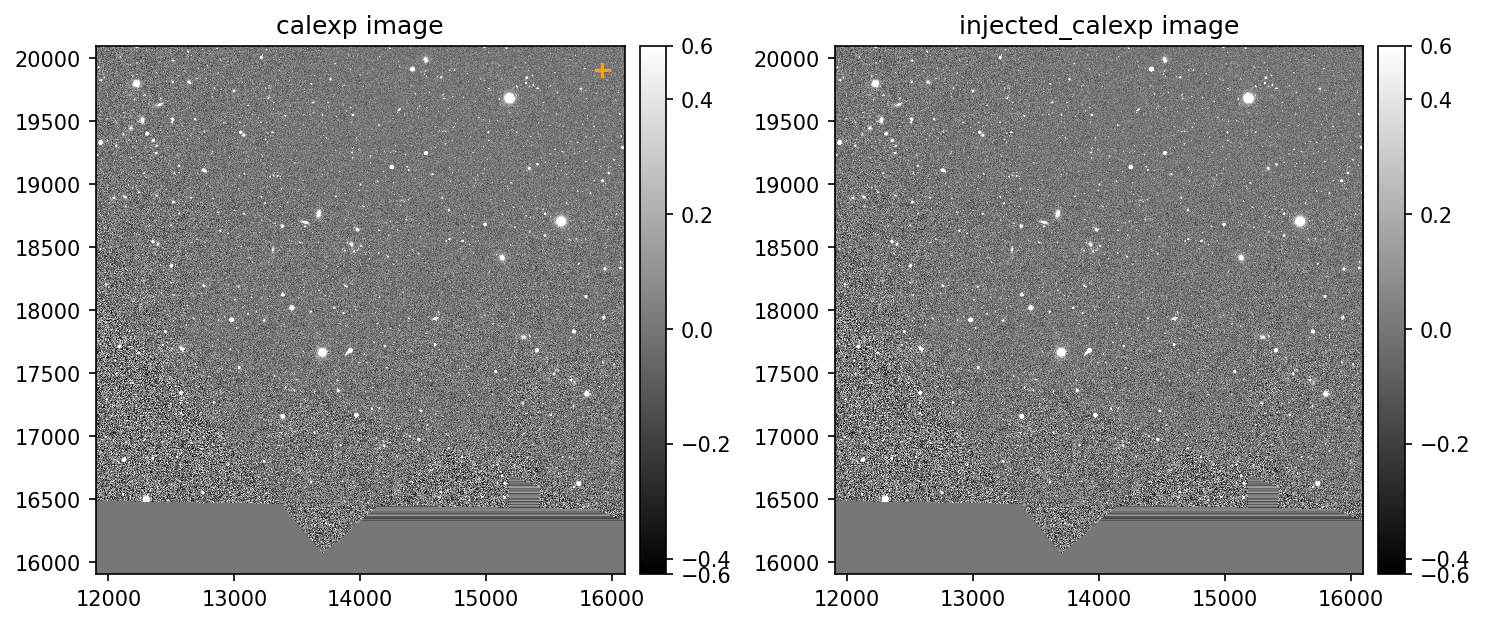

In [29]:
plot_injected_calexp = injected_exposure.clone()

fig, ax = plt.subplots(1, 2, figsize=(10, 6), dpi=150)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale('linear', 'zscale')
# display0.scale('linear', min=-20, max=150)
display0.mtv(coadd.image)

# wcs = deepCoadd_test.getWcs()
center = wcs.skyToPixel(radec)
display0.dot('+', center.x, center.y, size=50, ctype='orange')


plt.title('calexp image')

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
# display1.scale('linear', min=-20, max=150)
display1.mtv(plot_injected_calexp.image)
# To zoom on the PGC 038749 stamp:
display1.mtv(plot_injected_calexp.image)
plt.title('injected_calexp image')

plt.tight_layout()
plt.show()

In [30]:
center.x, center.y

(15922.072368000352, 19906.844189856696)

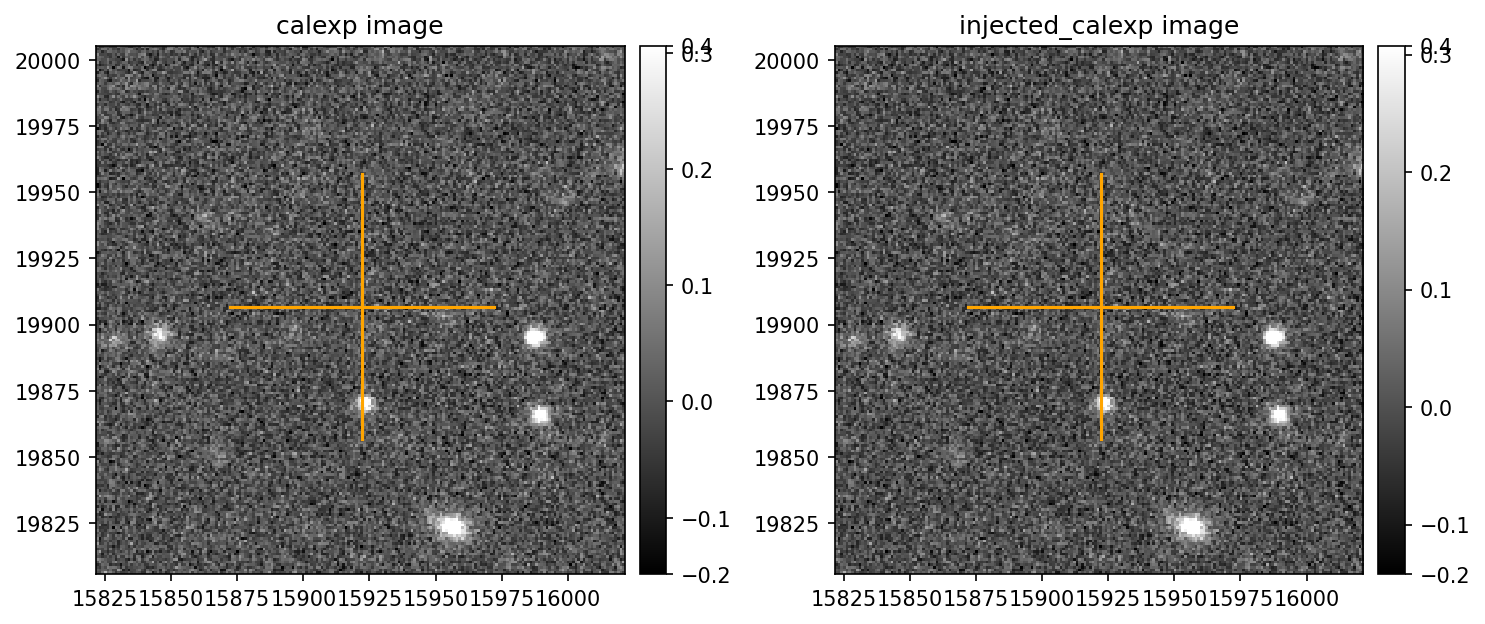

In [31]:
plot_injected_calexp = injected_exposure.clone()

fig, ax = plt.subplots(1, 2, figsize=(10, 6), dpi=150)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale('linear', 'zscale')
# display0.scale('linear', min=-20, max=150)
# wcs = deepCoadd_test.getWcs()
center = wcs.skyToPixel(radec)
display0.mtv(coadd.image[center.x-100:center.x+100, center.y-100:center.y+100])
display0.dot('+', center.x, center.y, size=50, ctype='orange')




plt.title('calexp image')

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
# display1.scale('linear', min=-20, max=150)
# display1.mtv(plot_injected_calexp.image)
# To zoom on the PGC 038749 stamp:
display1.mtv(plot_injected_calexp.image[center.x-100:center.x+100, center.y-100:center.y+100])
display1.dot('+', center.x, center.y, size=50, ctype='orange')
plt.title('injected_calexp image')

plt.tight_layout()
plt.show()

In [32]:
dataId = {'band': 'g', 'skymap': 'DC2', 'tract': 4849, 'patch': 31, 'instrument':'LSSTCam-imSim'}

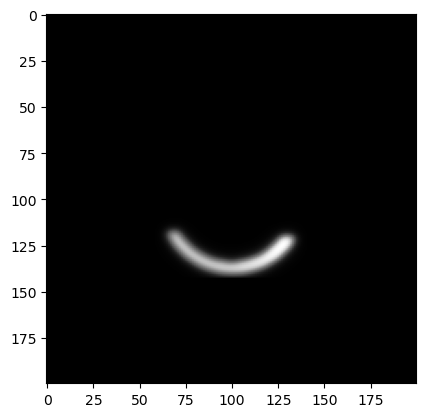

In [33]:
plt.imshow(coadd.image[center.x-100:center.x+100, center.y-100:center.y+100].array-
           plot_injected_calexp.image[center.x-100:center.x+100, center.y-100:center.y+100].array,
          cmap='Greys')